In [68]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import numpy as np
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

In [69]:
# データ読み込み
molecule_db = pd.read_csv('../datas/molecules.csv', names=['id', 'none', 'pubchem_id', 'common_name', 'flavor_profile'], header=0)
flavor_db = pd.read_csv('../datas/flavor_db.csv', names=['id', 'entry_id', 'alias', 'synonyms', 'scientific_name', 'category', 'molecules'], header=0)

flavor_db.drop(['id'], axis=1, inplace=True)
flavor_db.tail()

,,entry_id,alias,synonyms,scientific_name,category,molecules
935,935.0,0,egg,{'Egg'},Chicken,Animal Product,"{6274, 5311110, 644104, 9609, 18827, 527, 1960..."
936,936.0,979,olive oil,{''},Olea europaea L.,additive,"{6184, 31260, 5281168, 8103}"
937,NaN,980,Baking powder,NaN,NaN,NaN,"{11265, 62465, 644104, 12297, 31242, 527, 4114..."
938,NaN,981,Baking soda,NaN,NaN,NaN,{10340}
939,NaN,982,alum,NaN,NaN,NaN,{24856}


In [70]:
molecule_db.tail(20)

,id,none,pubchem_id,common_name,flavor_profile
1771,1771,1771.0,23676745,Potassium Sorbate,{'odorless'}
1772,1772,1772.0,24832101,"Santalol, alpha- and beta-","{'sandalwood', 'sweet', 'woody', 'deep'}"
1773,1773,1773.0,25021769,"2-Propen-1-one, 3-(4-hydroxyphenyl)-1-phenyl-",{'bitter'}
1774,1774,1774.0,44229138,(RS)-norcoclaurinium,"{'milky', 'sweet', 'fruity'}"
1775,1775,1775.0,46779070,S-Methyl 4-methylpentanethioate,{''}
1776,1776,1776.0,53425122,1-(Ethyltrisulfanyl)propane,"{'onion', 'alliaceous', 'green', 'garlic'}"
1777,1777,1777.0,53472027,D-Isoleucine Methyl Ester Hydrochloride,{''}
1778,1778,1778.0,54670067,l-ascorbic acid,{''}
1779,1779,1779.0,57346909,"4H-Pyrrolo[2,1-d]-1,3,5-dithiazine,tetrahydro-...",{''}
1780,1780,1780.0,57357963,33368-82-0,"{'sulfurous', 'alliaceous'}"


In [71]:
flavor_db.tail(2)

,,entry_id,alias,synonyms,scientific_name,category,molecules
938,NaN,981,Baking soda,NaN,NaN,NaN,{10340}
939,NaN,982,alum,NaN,NaN,NaN,{24856}


In [72]:
# kmeans分析のためにベクトル化したflavor_profileを作成してEntryに保存する
# Make all list of all flavors
all_flavors = molecule_db['flavor_profile'].apply(lambda x: x.replace("'", "").strip('{}').split(', ')).tolist()
unique_flavors = list(set([flavor for flavors in all_flavors for flavor in flavors]))
print(unique_flavors)

['', 'pine needle', 'watercress', 'acetone', 'glue', 'styrax', 'burnt', 'chemical', 'roast', 'citrus peel', 'minty', 'new mown hay', 'laundry', 'lovage', 'must', 'intensely', 'soybean', 'thujone', 'brown', 'pear', 'basil', 'fir', 'pastry', 'meat broth', 'bouillon', 'odorless', 'tart', 'cucumber', 'truffle', 'moth ball', 'nutmeg', 'blossom', 'creamy', 'petitgrain', 'narcissus', 'very strong', 'ripe', 'burnt sugar', 'anisic', 'sweet-like', 'rubbery', 'fishy', 'geranium', 'almond', 'fat', 'alcoholic', 'gasoline', 'gravy', 'cut privet', 'fecal', 'rhubarb', 'mimosa', 'alliaceous', 'plant', 'nut', 'amine', 'mandarin', 'molasses', 'strawberry', 'pork', 'deep', 'box tree', 'labdanum', 'iris', 'cereal', 'mild', 'orris', 'rose oxide', 'pepper', 'celery', 'syrup', 'stem', 'light', 'earthy', 'heliotropin', 'weedy', 'clove', 'lavender', 'painty', 'ambergris', 'ylang', 'castoreum', 'red hots', 'rum', 'popcorn', 'heather', 'dill', 'eucalyptus', 'absolute', 'mousy', 'savory', 'acrylate', 'bread crust'

In [73]:
# Word2Vecモデルを学習
model = Word2Vec(sentences=all_flavors, vector_size=100, window=5, min_count=1, sg=1)

# フレーバーのベクトルを確認
green_vector = model.wv['green']
print(green_vector)

[-0.11024731  0.08865121  0.00104234  0.05108663  0.02458184 -0.19736837
  0.12629808  0.31930017 -0.17324746  0.08396756 -0.03321015 -0.20425396
  0.00152838  0.03489222 -0.00610784 -0.09907925 -0.01383009 -0.19631614
 -0.11185078 -0.3518713   0.03383446  0.06877746  0.05494044 -0.08592452
 -0.11032649  0.02722137 -0.06767049 -0.07568916 -0.20336595 -0.00994436
  0.16688164 -0.05757504  0.08610387 -0.08225907 -0.15717286  0.14035916
  0.06974806 -0.12797907  0.03121371 -0.22622727  0.01563809 -0.20458741
 -0.07907134  0.06918976  0.1550309  -0.00907886 -0.16905282 -0.05399366
  0.2152504   0.08323916  0.05968301 -0.1051513   0.06531842  0.00069853
 -0.06990708  0.04625301  0.10835875 -0.05259502 -0.20486398  0.05590883
  0.04419304  0.02348708 -0.00402463 -0.11754941 -0.14710538  0.1499636
  0.05159127  0.25151354 -0.2215172   0.27388817 -0.0687238   0.00813129
  0.13377978 -0.04101782  0.1346872   0.06986355  0.05916374 -0.05064672
 -0.12126765 -0.00447821 -0.1270708  -0.05232897 -0.

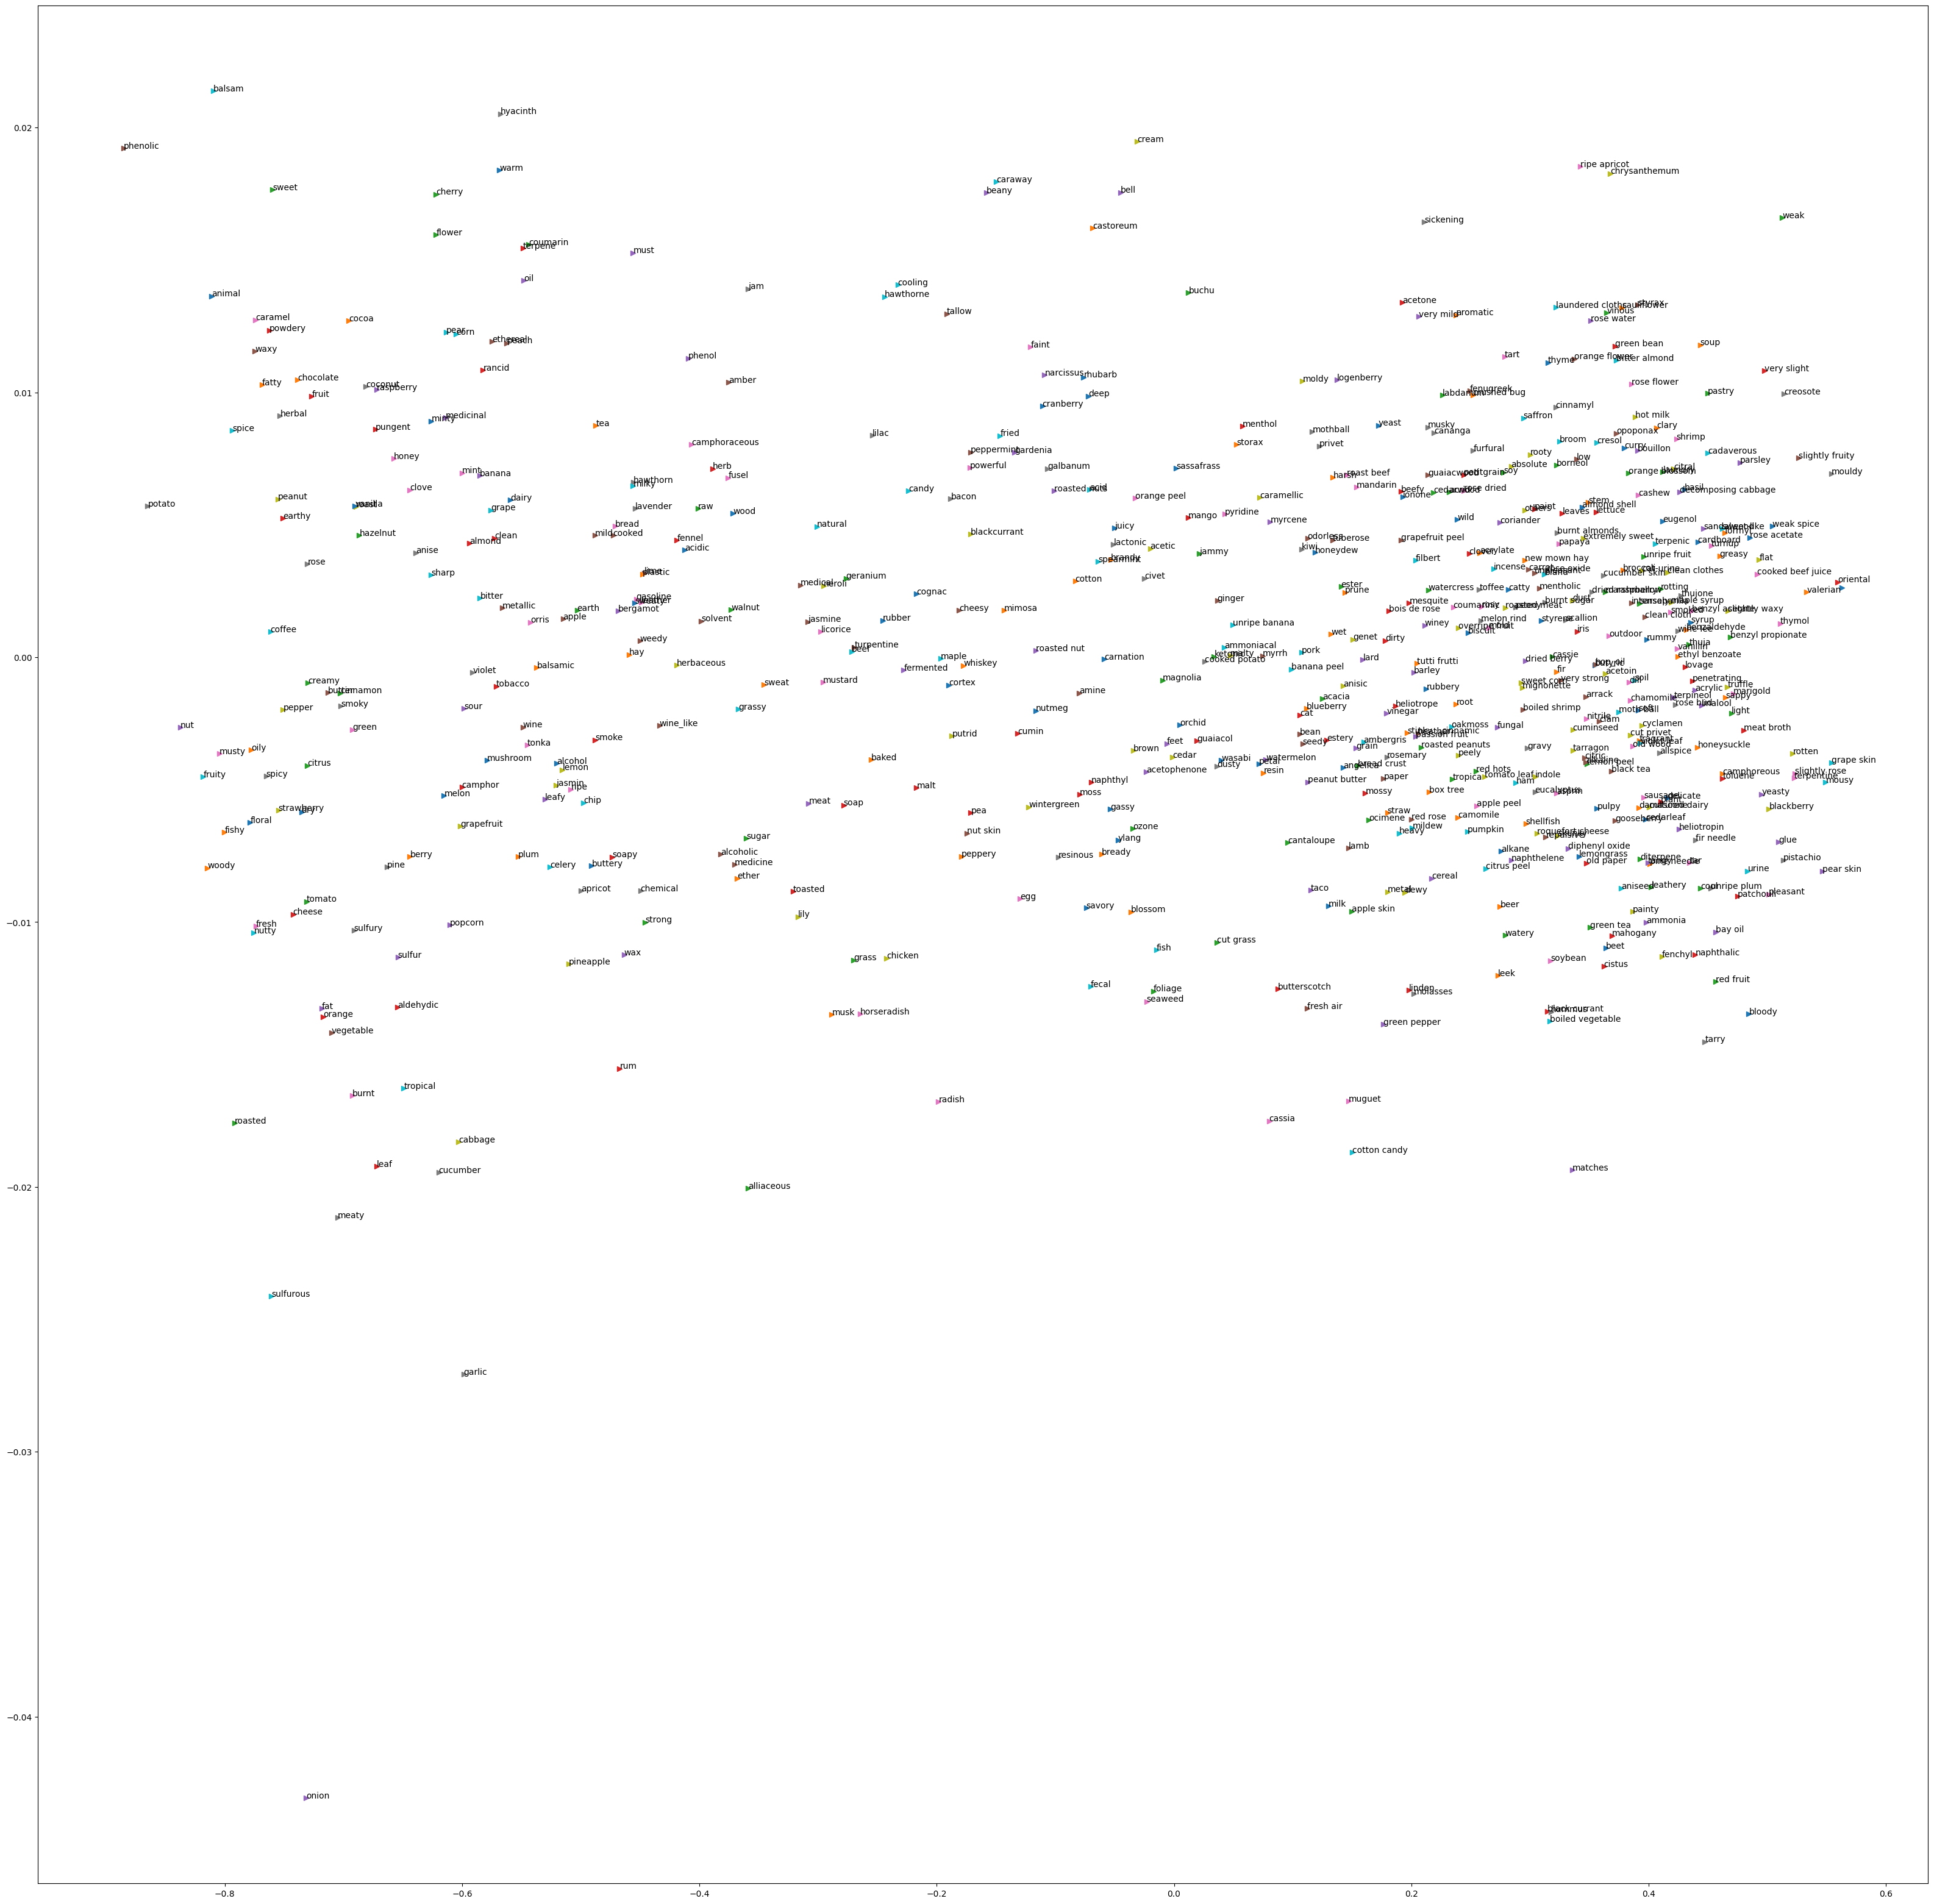

In [92]:
# いくつかの単語のベクトルを取得
wordvecs = []

for flav in unique_flavors:
    wordvecs.append(model.wv[flav])

# 主成分分析
pca = PCA(n_components=3)
pca.fit(wordvecs)

# 射影
X_2d = pca.transform(wordvecs)

# 可視化
plt.figure(figsize=(40, 40))
for i in range(len(unique_flavors)):
    plt.plot(X_2d[i][0], X_2d[i][1], marker='>')
    plt.annotate(unique_flavors[i],(X_2d[i][0], X_2d[i][1]))

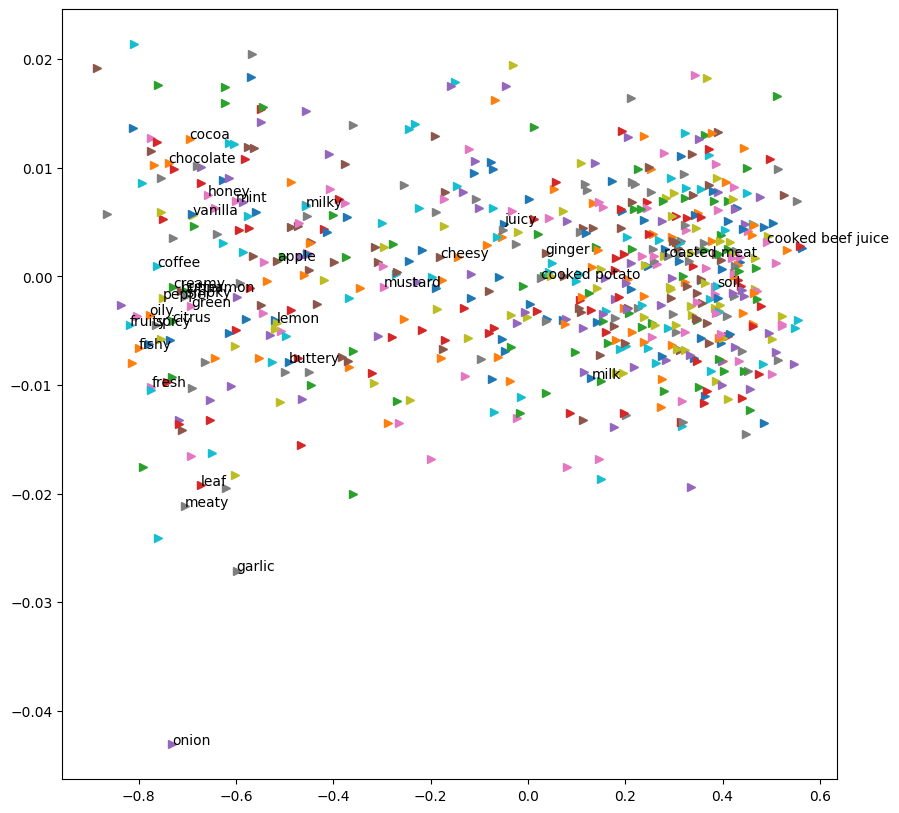

In [93]:
important_words = [
    'citrus', 'vanilla', 'fruity', 
    'lemon', 'chocolate', 'mint', 
    'butter','buttery', 
    'honey', 'cinnamon', 
    'coffee', 'soil',  
    'smoky', 'green',
    'pepper', 'leaf',
    'apple', 'leafy'
    'rose', 'spicy',
    'garlic','onion',
    'ginger','mustard',
    'meaty','cocoa', 'green '
    'fishy','creamy',
    'fruity','milk',
    'milky','juicy','cheesy',
    'cooked beef juice',
    'cooked potato', 'oily',
    'roasted meat', 'beer'
    'roasted nuts', 'woody'
    'spicy','fresh', 'citrus'
]
plt.figure(figsize=(10, 10))

for i in range(len(unique_flavors)):
    if unique_flavors[i] in important_words:
        plt.annotate(unique_flavors[i], (X_2d[i][0], X_2d[i][1]))
    plt.plot(X_2d[i][0], X_2d[i][1], marker='>')

plt.show()